# [Exploration 08] Movielens 영화 추천 

## 프로젝트 설명 
- 추천시스템 실습
- Movielens 데이터셋을 사용    
`
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
`
    - Movielens : 영화에 대한 평점을 매긴 데이터
    - 평점 데이터는 explicit데이터이지만, implicit데이터로 간주하고 테스트 진행 
    - 3점 미만은 비선호로 간주해 데이터셋에서 제외
- MF모델 사용

## 프로젝트 목표
-

## 01. load and preprocess data
- 3점 미만 평점 삭제합니다. 

In [3]:
import os
import pandas as pd

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


- 정수로 된 user_id, movie_id, 평점(rating), 재생시간(timestamp)을 확인    

**3점 이상의 데이터만 남깁니다.**

In [3]:
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


**파일이름(ratings)와 겹치지 않도록 컬럼 *rating*의 이름을 *count*로 바꿉니다.**

In [4]:
ratings.rename(columns={'rating':'count'}, inplace=True)
ratings['count']

/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

**메타 데이터('movies.dat')으로 영화 제목을 확인합니다.**

In [5]:
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding = 'ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


**ratings 데이터에서 예측한 후, 메타 데이터로 예측한 영화의 제목, 장르를 확인해 모델을 평가할 수 있을 것으로 보입니다.**

## 02. 데이터 파헤치기 
- 더 세부적인 정보를 얻기 위해 다음을 출력해보겠습니다.
    - ratings에 있는 유니크한 영화 개수
    - rating에 있는 유니크한 사용자 수
    - 가장 인기 있는 영화 30개(인기순)  

<AxesSubplot:xlabel='timestamp'>

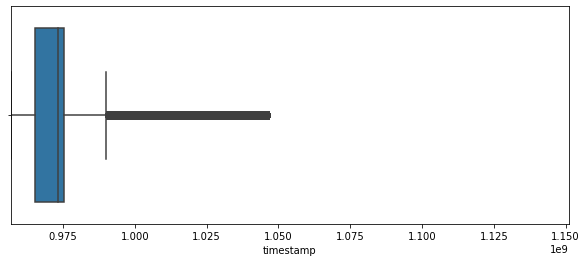

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,4))
plt.xlim(ratings.timestamp.min(), ratings.timestamp.max()*1.1)
sns.boxplot(x=ratings.timestamp)

In [6]:
ratings.head()

,user_id,movie_id,count,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
# 유니크한 사용자 수 
ratings['user_id'].nunique()

6039

In [8]:
# 유니크한 영화 개수 
ratings['movie_id'].nunique()

3628

In [9]:
# 인기 많은 영화
movies_count = ratings.groupby('movie_id')['user_id'].count()
movies_count.sort_values(ascending=False).head(30)

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

**id로 되어있는 영화들, 영화의 제목을 알아봅시다!**

In [10]:
movies_30 = movies_count.sort_values(ascending=False).head(30)
movies_30.head().keys()

Int64Index([2858, 260, 1196, 1210, 2028], dtype='int64', name='movie_id')

In [11]:

for i in movies_30.head().keys():
    movies_30_title.append(movies[movies['movie_id']==i])

movies_30_title

NameError: name 'movies_30_title' is not defined

**영화와 유저에 대한 통계, 영화 재생 시간에 대한 통계를 내보겠습니다.**

In [12]:
# 유저별 몇 편의 영화를 봤는지에 대한 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [14]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = ratings.groupby('user_id')['timestamp'].median()
user_median.describe()

count    6.039000e+03
mean     9.705019e+08
std      8.916703e+06
min      9.567058e+08
25%      9.650976e+08
50%      9.720067e+08
75%      9.748566e+08
max      1.045440e+09
Name: timestamp, dtype: float64

In [17]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_artist = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings.timestamp, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_artist))
csr_data

ValueError: row index exceeds matrix dimensions

## 03. 내가 선호하는 영화를 5가지 골라서 rating에 추가해 줍시다.
## 04. CSR matrix를 직접 만들어 봅시다.
## 05. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.
## 06. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.
## 07. 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.
## 08. 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

# 정리     
---        
1. 데이터 준비와 전처리
2. 분석해 봅시다.
- ratings에 있는 유니크한 영화 개수
- rating에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)  
3. 내가 선호하는 영화를 5가지 골라서 rating에 추가해 줍시다.
4. CSR matrix를 직접 만들어 봅시다.
5. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.
6. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.
7. 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.
8. 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.


# 루브릭 평가
---
1. **CSR matrix가 정상적으로 만들어졌다.**   
    - 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.


2. **MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.**  
    - 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.
    
     
3. **비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.**  
    - MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.

    
# 회고
---
## 더 공부하고 싶은 부분


## 느낀 점